In [55]:
#################################################
#created the 18/04/2018 12:57 by Alexis Blanchet#
#################################################

In [56]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import scipy.stats
import matplotlib
import plotly.offline as offline
import plotly.graph_objs as go
from sklearn.cluster import SpectralClustering
import plotly
import plotly.graph_objs as go
import plotly.offline as offline
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [57]:
def load_timeserie(file):
    data_file = open(file, 'r',os.O_NONBLOCK)
    data_file = data_file.read()
    datas = data_file.split('\n')
    data = [float(x) for x in datas[:-1]]
    return data
    

real_data = pd.read_csv('/home/alexis/Bureau/Stage/Time-series/clean data/sfrdaily_20171201_0_192_0_cleandata.csv',index_col=0)

In [58]:
real_data.head()

,values
1,3148165
2,3159788
3,3152419
4,3157207
5,3136355


let's no create some features.

In [59]:
from pandas import Series
from pandas import DataFrame
from pandas import concat

def add_noise(l):
    res = []
    for i in range(len(l)):
        res.append(l[i])
        m = max(res[-1]/10**8,1)
        res.append(np.random.normal(res[-1],m))
    return res

NOISE_LEVEL = 0
def shift_preprocess(data,noise_level=NOISE_LEVEL):
    temps = data['values'].values
    for i in range(noise_level):
        temps = add_noise(temps)
    temps = DataFrame(temps)
    dataframe = concat([temps.shift(3), temps.shift(2), temps.shift(1), temps], axis=1)
    dataframe.columns = ['t-3', 't-2', 't-1', 't']
    dataframe['minutes'] = dataframe.index
    dataframe = dataframe.drop(dataframe.index[[0,1,2]])
    print(dataframe.head())
    return dataframe

In [109]:
df= shift_preprocess(real_data)

         t-3        t-2        t-1        t  minutes
3  3148165.0  3159788.0  3152419.0  3157207        3
4  3159788.0  3152419.0  3157207.0  3136355        4
5  3152419.0  3157207.0  3136355.0  3123438        5
6  3157207.0  3136355.0  3123438.0  3147105        6
7  3136355.0  3123438.0  3147105.0  3148270        7


offline.plot({'data': [{'y': df['t'],'x':[(i)/((2**NOISE_LEVEL)*60) for i in range(len(df['t']))]}], 
               'layout': {'title': 'Test Plot', 
                          'font': dict(size=16)}},
             image='png')
                       

In [155]:
def KFDR(a,b):
    sigma = 0.5*a[1] + 0.5*b[1]
    return (((4**2/8)*(a[0]-b[0])**2)/(sigma + GAMMA))



def processing(dataframe):
    '''
    prend en entrée un dataframe contenant les shifts
    renvoie en sortie un dataframe de features
    permet le plot de certains features intéressants
    a compléter en fonction des features que l'on souhaite
    considérer ou non.

    '''
    SIGMA = 1
    L = 2000000
    GAMMA = 10
    THRESHOLD = max(dataframe['t'].values)/100
    dataframe["diff t t-1"]=dataframe.apply(lambda x:max(-THRESHOLD,min(THRESHOLD,x["t"]-x["t-1"])),axis = 1)
    dataframe["diff t t-2"]=dataframe.apply(lambda x:max(-THRESHOLD**2,min(THRESHOLD**2,x["t"]-x["t-2"])),axis = 1)
    dataframe["diff t t-3"]=dataframe.apply(lambda x:max(-THRESHOLD**2,min(THRESHOLD**2,x["t"]-x["t-3"])),axis = 1)
    dataframe["diff t-1 t-2"]=dataframe.apply(lambda x:max(-THRESHOLD,min(THRESHOLD**2,x["t-1"]-x["t-2"])),axis = 1)
    dataframe["diff t-1 t-3"]=dataframe.apply(lambda x:max(-THRESHOLD**2,min(THRESHOLD**2,x["t-1"]-x["t-3"])),axis = 1)
    dataframe["diff t-2 t-3"]=dataframe.apply(lambda x:max(-THRESHOLD,min(THRESHOLD,x["t-2"]-x["t-3"])),axis = 1)
    
    dataframe["mean"]=(dataframe["t"]+dataframe["t-1"]+dataframe["t-2"]+dataframe["t-3"])/4
    dataframe["distance to mean"] = dataframe.apply(lambda x:max(-THRESHOLD,min(10**7,(x["t"]-x["mean"])/x["t"])),axis = 1)
    dataframe["pente t t-2"] = dataframe.apply(lambda x:max(-THRESHOLD,min(THRESHOLD,x["diff t t-2"]/2)),axis = 1)
    dataframe["pente t t-3"] = dataframe.apply(lambda x:max(-THRESHOLD,min(THRESHOLD,x["diff t t-3"]/3)),axis = 1)
    dataframe["pente t-1 t-3"] = dataframe.apply(lambda x:max(-THRESHOLD,min(THRESHOLD,x["diff t-1 t-3"]/2)),axis = 1)
    
    
    dataframe["diff pente 1-2"] = (dataframe["diff t t-1"] - dataframe["diff t-1 t-2"])/dataframe["diff t t-1"]
    dataframe["diff pente 1-3"] = (dataframe["diff t t-1"] - dataframe["diff t-2 t-3"])/dataframe["diff t t-1"]
    dataframe["diff pente 2-3"] = (dataframe["diff t-1 t-2"] - dataframe["diff t-2 t-3"])/dataframe["diff t-1 t-2"]
    
    dataframe['GP'] = (SIGMA**2)*(np.exp(-((df['t']-df['t-1'])**2)/df['t']**2))
    dataframe['covariance'] = 0.25*((dataframe['t']-dataframe['mean'])**2 + (dataframe['t-1']-dataframe['mean'])**2 +(dataframe['t-2']-dataframe['mean'])**2 + (dataframe['t-3']-dataframe['mean'])**2)
    
    h = [0,0]
    for index, row in dataframe.iterrows():
        dataframe.set_value(index, 'KDFR', KFDR([row['mean'],row['covariance']],h))
        h = [row['mean'],row['covariance']]
    dataframe.set_value(3, 'KDFR', 1.5)
    
    x = dataframe["diff t t-1"]
    m = np.mean(x)
    sd = sum([(y-m)**2 for y in x])/(len(x)-1)
    #print("moyenne: %s   standard deviation: %s" %(str(m),str(sd)))

    d = scipy.stats.norm(m, sd)
    time = [i/((2**NOISE_LEVEL)*60) for i in range(len(x))]
    prob = [ d.pdf(y) for y in x]
    dist = [ d.cdf(y) for y in x]
    dataframe["probability"] = prob
    dataframe["distribution"] = dist

    dataframe["skewness"]= ((3)**0.5)*(((dataframe['t']-dataframe["mean"])**3)/4+((dataframe['t-1']-dataframe["mean"])**3)/4
                            +((dataframe['t-2']-dataframe["mean"])**3)/4+((dataframe['t-3']-dataframe["mean"])**3)/4)/(sd**3)
    dataframe["skewness"]= (((dataframe['t']-dataframe["mean"])**4)/4+((dataframe['t-1']-dataframe["mean"])**4)/4
                            +((dataframe['t-2']-dataframe["mean"])**4)/4+((dataframe['t-3']-dataframe["mean"])**4)/4)/(sd**4)
    '''
    plt.subplot(2, 1, 1)
    plt.plot(time,prob, '-')
    ax=plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
    plt.title('probability and distribution of the change in the number of viewers')

    plt.subplot(2, 1, 2)
    plt.plot(time,dist, '.-')
    ax=plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
    plt.xlabel('time (arbitrary)')
    plt.savefig('data/png/'+name+'-1.png')
    plt.close()
    '''
    return dataframe


In [156]:
df = processing(df)
df.describe()

,t-3,t-2,t-1,t,minutes,diff t t-1,diff t t-2,diff t t-3,diff t-1 t-2,diff t-1 t-3,...,pente t-1 t-3,diff pente 1-2,diff pente 1-3,diff pente 2-3,GP,probability,distribution,skewness,covariance,KDFR
count,1.437000e+03,1.437000e+03,1.437000e+03,1.437000e+03,1437.000000,1.437000e+03,1.437000e+03,1.437000e+03,1.437000e+03,1.437000e+03,...,1.437000e+03,1437.000000,1437.000000,1437.000000,1437.000000,1.437000e+03,1.437000e+03,1.437000e+03,1.437000e+03,1.437000e+03
mean,1.097211e+08,1.097222e+08,1.097233e+08,1.097244e+08,721.000000,1.014622e+05,2.245182e+03,3.355040e+03,2.294335e+05,2.243330e+03,...,8.681235e+04,-0.209384,-0.447729,-0.161631,0.999526,1.865585e-13,5.000000e-01,1.050679e-22,8.535440e+12,1.264235e+00
std,9.545224e+07,9.545101e+07,9.544976e+07,9.544852e+07,414.970481,1.462337e+06,5.337926e+06,7.263375e+06,2.059206e+06,5.337926e+06,...,1.439364e+06,16.634629,18.912266,16.626834,0.001616,7.782958e-26,2.728115e-07,8.136095e-22,3.566463e+13,5.444116e-01
min,2.140637e+06,2.140637e+06,2.140637e+06,2.140637e+06,3.000000,-3.498425e+06,-4.089372e+07,-5.021018e+07,-3.498425e+06,-4.089372e+07,...,-3.498425e+06,-559.968254,-456.015873,-559.968254,0.978178,1.865585e-13,4.999993e-01,2.587483e-37,1.703520e+06,4.931832e-07
25%,2.507339e+07,2.507339e+07,2.507339e+07,2.507339e+07,362.000000,-4.060110e+05,-7.501210e+05,-1.230000e+06,-4.060110e+05,-7.501210e+05,...,-3.750605e+05,-0.355297,-0.328626,-0.275477,0.999691,1.865585e-13,4.999999e-01,1.210447e-28,3.831431e+10,9.435824e-01
50%,1.012156e+08,1.012156e+08,1.012156e+08,1.012156e+08,721.000000,2.366700e+04,3.847300e+04,5.618100e+04,2.366700e+04,3.847300e+04,...,1.923650e+04,0.045013,0.157635,0.097964,0.999923,1.865585e-13,5.000000e-01,9.675424e-27,3.345258e+11,1.426924e+00
75%,1.775686e+08,1.775686e+08,1.775686e+08,1.775686e+08,1080.000000,5.547150e+05,1.022173e+06,1.535548e+06,5.547150e+05,1.022173e+06,...,5.110865e+05,0.657749,0.949343,0.671866,0.999985,1.865585e-13,5.000001e-01,5.239350e-25,2.564807e+12,1.626746e+00
max,3.498425e+08,3.498425e+08,3.498425e+08,3.498425e+08,1439.000000,3.498425e+06,4.387475e+07,5.229611e+07,3.512721e+07,4.387475e+07,...,3.498425e+06,105.140830,85.831502,105.140830,1.000000,1.865585e-13,5.000006e-01,1.349010e-20,4.961071e+14,2.602577e+00


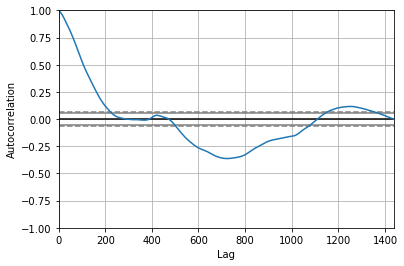

            t       t-1
t    1.000000  0.999508
t-1  0.999508  1.000000


In [87]:
from pandas.tools.plotting import autocorrelation_plot

series = df[['t','t-1']]
autocorrelation_plot(series)
plt.show()
result = series.corr()
print(result)


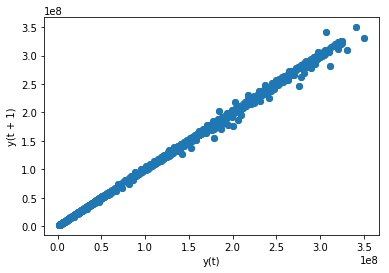

In [84]:
from pandas.tools.plotting import lag_plot
series = df[['t','t-1']]
lag_plot(series)
plt.show()

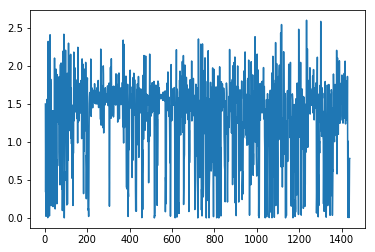

In [154]:
from sklearn.metrics import mean_squared_error
dataframe = df[['t','t-1','t-2','t-3']]
# split into train and test sets
X = dataframe.values



from sklearn.metrics import mean_squared_error
from scipy import stats

dataframe['mean'] = 0.25*(dataframe['t']+dataframe['t-1']+dataframe['t-2']+dataframe['t-3'])



plt.plot(dataframe['KDFR'])    


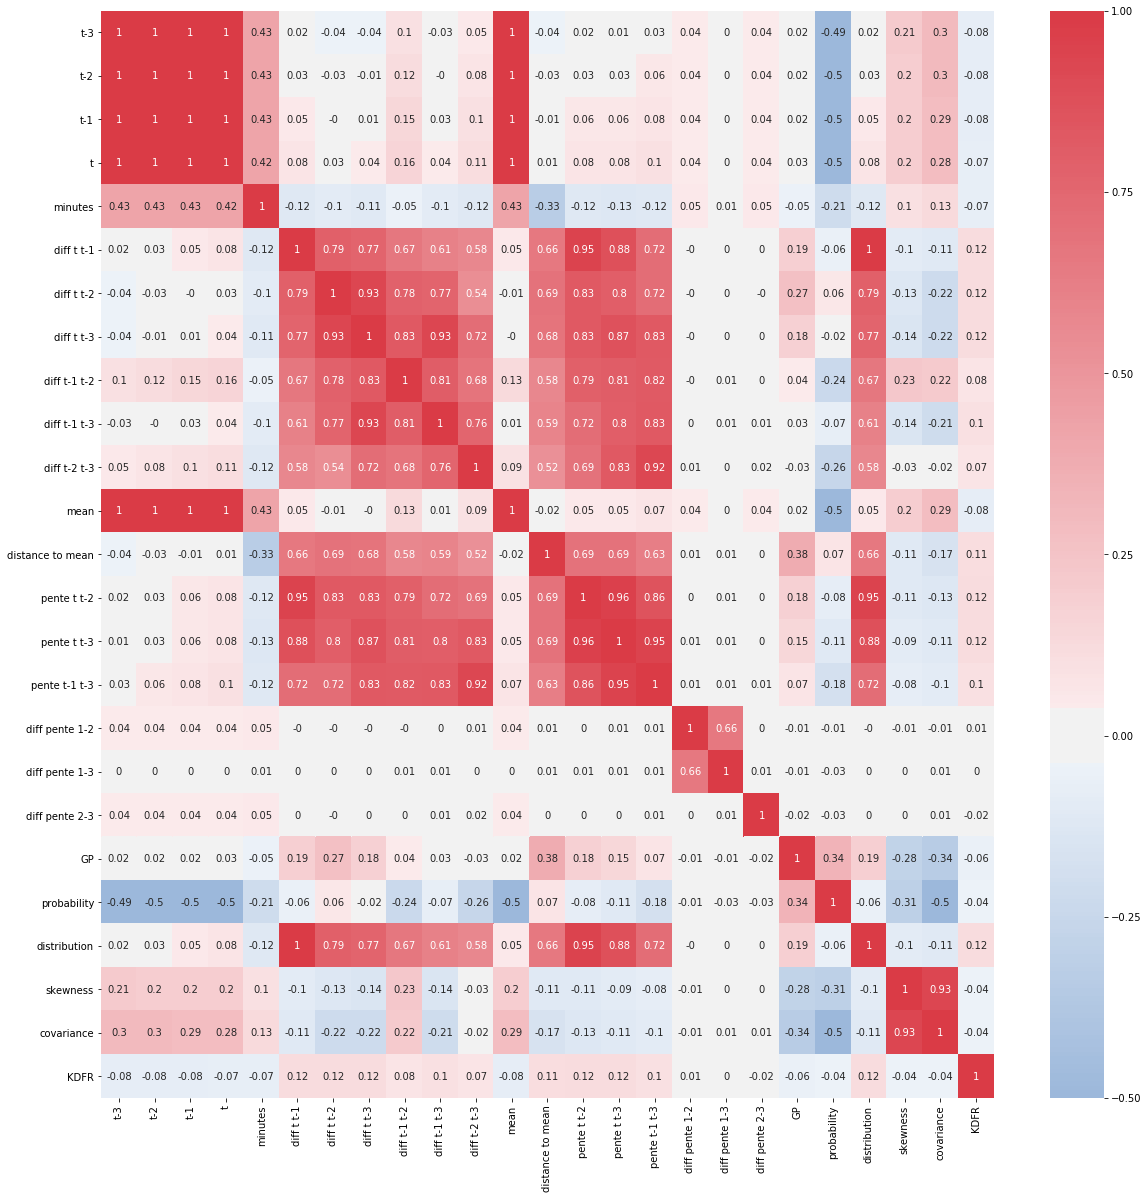

In [157]:
import seaborn as sns
### Corralation matrix heatmap### Corr 
# Getting correlation matrix
cor_matrix = df.corr().round(2)
# Plotting heatmap 
fig = plt.figure(figsize=(20,20));
sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()

In [158]:
names = df.columns.values
names

array(['t-3', 't-2', 't-1', 't', 'minutes', 'diff t t-1', 'diff t t-2',
       'diff t t-3', 'diff t-1 t-2', 'diff t-1 t-3', 'diff t-2 t-3',
       'mean', 'distance to mean', 'pente t t-2', 'pente t t-3',
       'pente t-1 t-3', 'diff pente 1-2', 'diff pente 1-3',
       'diff pente 2-3', 'GP', 'probability', 'distribution', 'skewness',
       'covariance', 'KDFR'], dtype=object)

In [48]:
df2 = df.describe()
df2.head()


,t-3,t-2,t-1,t,minutes,diff t t-1,diff t t-2,diff t t-3,diff t-1 t-2,diff t-1 t-3,diff t-2 t-3,mean,distance to mean,pente t t-2,pente t t-3,pente t-1 t-3,probability,distribution,skewness
count,1.437000e+03,1.437000e+03,1.437000e+03,1.437000e+03,1437.000000,1.437000e+03,1.437000e+03,1.437000e+03,1.437000e+03,1.437000e+03,1.437000e+03,1.437000e+03,1437.000000,1.437000e+03,1.437000e+03,1.437000e+03,1.437000e+03,1.437000e+03,1.437000e+03
mean,1.097211e+08,1.097222e+08,1.097233e+08,1.097244e+08,721.000000,1.014622e+05,2.245182e+03,3.355040e+03,2.294335e+05,2.243330e+03,1.014604e+05,1.097227e+08,-0.000223,8.681327e+04,6.692264e+04,8.681235e+04,1.865585e-13,5.000000e-01,1.050679e-22
std,9.545224e+07,9.545101e+07,9.544976e+07,9.544852e+07,414.970481,1.462337e+06,5.337926e+06,7.263375e+06,2.059206e+06,5.337926e+06,1.462336e+06,9.540563e+07,0.029086,1.439364e+06,1.429933e+06,1.439364e+06,7.782958e-26,2.728115e-07,8.136095e-22
min,2.140637e+06,2.140637e+06,2.140637e+06,2.140637e+06,3.000000,-3.498425e+06,-4.089372e+07,-5.021018e+07,-3.498425e+06,-4.089372e+07,-3.498425e+06,2.145253e+06,-0.156476,-3.498425e+06,-3.498425e+06,-3.498425e+06,1.865585e-13,4.999993e-01,2.587483e-37
25%,2.507339e+07,2.507339e+07,2.507339e+07,2.507339e+07,362.000000,-4.060110e+05,-7.501210e+05,-1.230000e+06,-4.060110e+05,-7.501210e+05,-4.060110e+05,2.495980e+07,-0.009979,-3.750605e+05,-4.100000e+05,-3.750605e+05,1.865585e-13,4.999999e-01,1.210447e-28


In [49]:
df2.loc[['std']]['mean'].values

array([ 95405631.98761934])

In [50]:
irrelevant = ('t-3', 't-2', 't-1', 't','minutes', 'diff t t-1', 'diff t t-2','diff t t-3', 'diff t-1 t-2', 'diff t-1 t-3', 'diff t-2 t-3','mean')
allnames = df.columns
names = list(set(allnames) - set(irrelevant))
print(names)
temp_df = df[names]
temp_df.head()

['distribution', 'pente t-1 t-3', 'pente t t-2', 'pente t t-3', 'probability', 'skewness', 'distance to mean']


,distribution,pente t-1 t-3,pente t t-2,pente t t-3,probability,skewness,distance to mean
3,0.5,2127.0,-1290.5,3014.000000,1.865585e-13,2.905194e-35,0.000891
4,0.5,-1290.5,-8032.0,-7811.000000,1.865585e-13,6.906554e-34,-0.004810
5,0.5,-8032.0,-16884.5,-9660.333333,1.865585e-13,2.250786e-33,-0.006056
6,0.5,-16884.5,5375.0,-3367.333333,1.865585e-13,1.985593e-33,0.001932
7,0.5,5375.0,12416.0,3971.666667,1.865585e-13,8.184194e-34,0.003011


In [51]:
def find_index(l,v):
    res = []
    for i, j in enumerate(l):
        if(j == v):
            res.append(i)
    return res

In [54]:
def annomalie_detection(df,automatic_threshold = True):
    '''
    prend en entrée un DataFrame
    renvoie en sortie une liste de points ou il y a annomalie
    les threshold sont a déterminer manuellement pour le moment
    on peut cependant essayer de les fixer de manière automatique
    en fonction de l'historique de la chaîne/departement/regroupement(csp)
    '''
    if(automatic_threshold):
        res = []
        irrelevant = ('t-3', 't-2', 't-1', 't','minutes', 'diff t t-1', 'diff t t-2','diff t t-3', 'diff t-1 t-2', 'diff t-1 t-3', 'diff t-2 t-3','mean')
        allnames = df.columns
        names = list(set(allnames) - set(irrelevant))

        temp_df = df[names]
        info = df.describe()
    
    
        X = temp_df.values
        connectivity = kneighbors_graph(X, n_neighbors=50, include_self=False)
        agglomerative = AgglomerativeClustering(n_clusters=50,connectivity=connectivity,linkage="average")
        #spectral = SpectralClustering(n_clusters=4,affinity="nearest_neighbors",n_neighbors = 4)
        y_pred = agglomerative.fit_predict(X)  
            
        temp_df['signe'] = np.sign(temp_df['pente t t-2']+temp_df['pente t-1 t-3']+temp_df['pente t t-3'])
        #['pente t t-2', 'distribution', 'pente t-1 t-3', 'probability', 'pente t t-3', 'distance to mean']
        poids = [2,3,1,3,2,3]
        ptot = sum(poids)
        for name,p in zip(names,poids):
            m = df2.loc[['mean']][name].values[0]
            sd = df2.loc[['std']][name].values[0]
            d = scipy.stats.norm(m, sd)
            temp_df[name] = temp_df[name].apply(lambda x: p*d.cdf(x))


        temp_df['proba'] = temp_df[names].sum(axis = 1)
        temp_df['proba'] = temp_df['proba'].apply(lambda x: abs((x-ptot*0.5)/ptot))

        temp_df['annomalies'] =  temp_df['proba'].apply(threshold) 

        res = temp_df['annomalies']*temp_df['signe']
    
        

    else:
        pass
        #TODO:implement a xgboost to determine annomalies
        # load model from file
        loaded_model = pickle.load(open("pima.pickle.dat", "rb"))
        # make predictions for test data
        y_pred = loaded_model.predict_proba(df.values)

    return res,y_pred

def threshold(x):
    if(x>0.15):
        return 1
    else:
        return 0
    

def plot_annomalies(annomalies,df,name):
    """
    prend en entrée le nombres d'indicateurs qui detectent une annomalie
    ainsi que le datafame contenant tous les features(on a effacé 3 lignes)
    renvoie un graph présentant les zones d'incertitudes quand a la présence
    d'un événement important dans la plage horaire
    """
    
    annomalies = list(annomalies)
    l1 = find_index(annomalies,0)
    l2 = find_index(annomalies,-1)
    l3 = find_index(annomalies,1)

    x = df['t'].values
    t= [i/(60*2**(max([NOISE_LEVEL-1,0])))+3 for i in range(len(y))]
    x1 = [t[i] for i in l1]
    x2 = [t[i] for i in l2]
    x3 = [t[i] for i in l3]
    y1 = [x[i] for i in l1]
    y2 = [x[i] for i in l2]
    y3 = [x[i] for i in l3]

    trace1 = go.Scatter(
        x=x1,
        y=y1,
            mode = 'markers'
    )
    trace2 = go.Scatter(
        x=x2,
        y=y2,
        mode = 'markers'
    )
    trace3 = go.Scatter(
        x=x3,
        y=y3,
        mode = 'markers'
    )
    fig = tools.make_subplots(rows=3, cols=1, specs=[[{}], [{}], [{}]],
                              shared_xaxes=True, shared_yaxes=True,
                              vertical_spacing=0.001)
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 1)
    fig.append_trace(trace3, 1, 1)

    fig['layout'].update(height=2000, width=2000, title='Annomalie detection')
    plot(fig, filename='data/'+name+'.html')

annomalies,y = annomalie_detection(df) 
plot_annomalies(annomalies,df,'test')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]



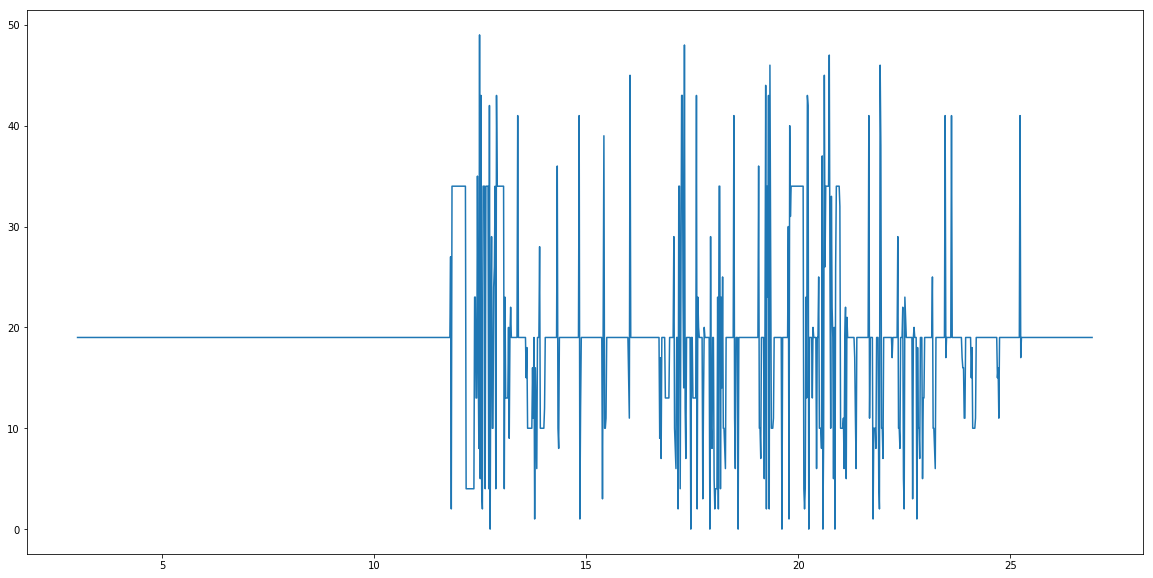

In [53]:
t= [i/(60*2**(max([NOISE_LEVEL-1,0])))+3 for i in range(len(y))]
plt.figure(figsize=(20,10))
plt.plot(t,y)

In [ ]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()
import plotly.offline as offline
import plotly.graph_objs as go
init_notebook_mode(connected=True)


annomalies = list(annomalies)
l1 = find_index(annomalies,0)
l2 = find_index(annomalies,-1)
l3 = find_index(annomalies,1)

x = df['t'].values
t= [i/(60*2**NOISE_LEVEL) for i in range(len(x))]
x1 = [t[i] for i in l1]
x2 = [t[i] for i in l2]
x3 = [t[i] for i in l3]
y1 = [x[i] for i in l1]
y2 = [x[i] for i in l2]
y3 = [x[i] for i in l3]

'''
plt.plot(x1, y1, 'g') # plotting t, a separately 
plt.plot(x2, y2, 'r+') # plotting t, b separately 
plt.plot(x3, y3, 'b+') # plotting t, c separately 
plt.show()

plt.savefig("colored_trend.png")
'''

from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=x1,
    y=y1,
    
)
trace2 = go.Scatter(
    x=x2,
    y=y2,
    mode = 'markers'
)
trace3 = go.Scatter(
    x=x3,
    y=y3,
    mode = 'markers'
)
fig = tools.make_subplots(rows=3, cols=1, specs=[[{}], [{}], [{}]],
                          shared_xaxes=True, shared_yaxes=True,
                          vertical_spacing=0.001)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)
fig.append_trace(trace3, 1, 1)

fig['layout'].update(height=600, width=600, title='Stacked Subplots with Shared X-Axes')
plotly.offline.iplot(fig)

In [ ]:
def sum_list(a,b):
    c = [x+y for x,y in zip(a,b)]
    return c

In [ ]:
#####################################################
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
######################################################
### XGB modeling
params = {'eta': 0.02,
          'max_depth': 9, 
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel':0.9,
          'min_child_weight':5,
          'alpha':2,
          'objective': 'multi:softprob',
          'num_class':3,
          'eval_metric': 'mlogloss',
          'seed': 99,
          'silent': False}
params2 = {'eta': 0.02,
          'max_depth': 8, 
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel':0.9,
          'min_child_weight':5,
          'alpha':1,
          'objective': 'multi:softprob',
          'num_class':3,
          'eval_metric': 'mlogloss',
          'seed': 99,
          'silent': False}
######################################################
class Classifier(BaseEstimator):
    def __init__(self):
        pass
 
    def fit(self, X, y):
        x1, x2, y1, y2 = train_test_split(X, y[:X.shape[0]], test_size=0.2, random_state=99)
        watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
        self.clf1 = xgb.train(params, xgb.DMatrix(x1, y1), 5000,  watchlist, maximize = False,verbose_eval=100, early_stopping_rounds=300)
        self.clf2 = xgb.train(params2, xgb.DMatrix(x1, y1), 5000,  watchlist, maximize = False,verbose_eval=100, early_stopping_rounds=300)
        
       
    def predict(self, X):
        return self.clf.predict(X)
 
    def predict_proba(self, X):
        res1 = self.clf1.predict(xgb.DMatrix(X), ntree_limit=self.clf1.best_ntree_limit)
        res2 = self.clf2.predict(xgb.DMatrix(X), ntree_limit=self.clf2.best_ntree_limit)
        res = [ sum_list(a,b) for a,b in zip(res1,res2)]
        return res
    